# Image segmentation using *U-Net* model with insight into learning process via *captum.ai*

*U-Net* model explanation: *https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28*

Dataset: *https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/fss1000-a-1000-class-fewshot-segmentation*

---

**Environment preparation:**

In [ ]:
# INSTALL kaggle UTILITY

!pip install kaggle

In [ ]:
# UPLOAD kaggle.json TO Colab ENVIRONMENT

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annamariiaandrushko","key":"31ff2e7847adef95b417b02e61745995"}'}

In [ ]:
# MOVE kaggle.json TO THE ACCESS FOLDER AND GRANT IT r-w PERMISSIONS

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
# IMPORT THE DATASET FROM kaggle

!kaggle datasets download -d meowmeowmeowmeowmeow/fss1000-a-1000-class-fewshot-segmentation

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/fss1000-a-1000-class-fewshot-segmentation
License(s): other
 99% 641M/649M [00:09<00:00, 67.5MB/s]
100% 649M/649M [00:09<00:00, 71.4MB/s]


In [2]:
# UNZIP THE DATASET

!unzip fss1000-a-1000-class-fewshot-segmentation.zip -d /content/FSS-1000

Streaming output truncated to the last 5000 lines.
  inflating: /content/FSS-1000/FSS-1000/schooner/10.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/10.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/2.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/2.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/3.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/3.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/4.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/4.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/5.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/5.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/6.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/6.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/7.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/7.png  
  inflating: /content/FSS-1000/FSS-1000/schooner/8.jpg  
  inflating: /content/FSS-1000/FSS-1000/schooner/8.png  
  inflating: /content/FSS-1000/FSS-

---

**Data preparation:**

In [3]:
# LIST OF IMPORTS

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn

In [4]:
# DEFINE PATH TO THE DATASET AND CHECK ITS STRUCTURE

dataset_path = "/content/FSS-1000"

print("Contents of the dataset path:")
print(os.listdir(dataset_path))

Contents of the dataset path:
['fss-1000.csv', 'FSS-1000']


In [5]:
# CHECK THE STRUCTURE OF THE MAIN FOLDER

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"Contents of {folder}:")
        print(os.listdir(folder_path))

Contents of FSS-1000:
['knife', 'camel', 'school_bus', 'totem_pole', 'sombrero', 'tray', 'flute', 'swim_ring', 'leeks', 'fly', 'boxing_gloves', 'shotgun', 'boa_constrictor', 'teapot', 'pizza', 'folding_chair', 'loguat', 'lobster', 'remote_control', 'redheart', 'egg_tart', 'cablestayed_bridge', 'streetcar', 'cabbage', 'beaver', 'haddock', 'vine_snake', 'pinwheel', 'crane', 'golf_ball', 'crab', 'eel', 'running_shoe', 'jay_bird', 'scabbard', 'turnstile', 'baseball', 'parthenon', 'diaper', 'marimba', 'afghan_hound', 'adidas_logo2', 'anise', 'cathedrale_paris', 'scissors', 'woodpecker', 'magpie_bird', 'fish', 'fire_hydrant', 'big_ben', 'miniskirt', 'lawn_mower', 'lacewing', 'rubick_cube', 'apple_icon', 'plastic_bag', 'oiltank_car', 'soymilk_machine', 'andean_condor', 'langur', 'vacuum', 'cornet', 'pyramid', 'great_wall', 'one-armed_bandit', 'wardrobe', 'sulphur_butterfly', 'rabbit', 'net_surface_shoes', 'spoonbill', 'flying_snakes', 'snake', 'rock_snake', 'basketball', 'revolver', 'car_mirr

In [6]:
# CHECK THE STRUCTURE OF THE SUBFOLDERS WITH IMAGES AND MASKS

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"Contents of {subfolder}:")
        print(os.listdir(subfolder_path))

Contents of knife:
['9.png', '8.jpg', '7.png', '6.jpg', '5.png', '4.png', '4.jpg', '10.png', '7.jpg', '8.png', '3.png', '6.png', '3.jpg', '1.png', '5.jpg', '9.jpg', '2.jpg', '10.jpg', '1.jpg', '2.png']
Contents of camel:
['9.png', '8.jpg', '7.png', '6.jpg', '5.png', '4.png', '4.jpg', '10.png', '7.jpg', '8.png', '3.png', '6.png', '3.jpg', '1.png', '5.jpg', '9.jpg', '2.jpg', '10.jpg', '1.jpg', '2.png']
Contents of school_bus:
['9.png', '8.jpg', '7.png', '6.jpg', '5.png', '4.png', '4.jpg', '10.png', '7.jpg', '8.png', '3.png', '6.png', '3.jpg', '1.png', '5.jpg', '9.jpg', '2.jpg', '10.jpg', '1.jpg', '2.png']
Contents of totem_pole:
['9.png', '8.jpg', '7.png', '6.jpg', '5.png', '4.png', '4.jpg', '10.png', '7.jpg', '8.png', '3.png', '6.png', '3.jpg', '1.png', '5.jpg', '9.jpg', '2.jpg', '10.jpg', '1.jpg', '2.png']
Contents of sombrero:
['9.png', '8.jpg', '7.png', '6.jpg', '5.png', '4.png', '4.jpg', '10.png', '7.jpg', '8.png', '3.png', '6.png', '3.jpg', '1.png', '5.jpg', '9.jpg', '2.jpg', '10.j

In [7]:
# NORMALISE IMAGES AND MASKS

# DEFINE PATHS TO THE MAIN FOLDER AND NEW FOLDERS FOR PROCESSED IMAGES AND MASKS
main_path = "/content/FSS-1000/FSS-1000"
image_dir = "/content/processed_images"
mask_dir = "/content/processed_masks"

# CREATE DIRECTORIES FOR THE NORMALISED IMAGES AND MASKS
os.makedirs(image_dir, exist_ok = True)
os.makedirs(mask_dir, exist_ok = True)

# TARGET SIZE FOR NORMALISATION
target_size = (128, 128)

def normalise(input_folder, output_folder, is_mask):
    for subfolder in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder)
        if os.path.isdir(subfolder_path):
            print(f"Processing the subfolder folder: {subfolder}")
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                if (not is_mask and file_name.endswith('.jpg')) or (is_mask and file_name.endswith('.png')):

                    # DIFFERENTIATE IMAGES AND MASKS
                    flag = cv2.IMREAD_GRAYSCALE if is_mask else cv2.IMREAD_COLOR
                    img = cv2.imread(file_path, flag)

                    # RESIZE AND NORMALISE
                    img_resized = cv2.resize(img, target_size)
                    img_normalised = img_resized / 255.0
                    if is_mask:
                        img_normalised = np.expand_dims(img_normalised, axis = -1)  # FOR MASKS, ADD CHANNEL DIMENSION AT THE END

                    # SAVE AS .npy FILE
                    output_path = os.path.join(output_folder, f"{subfolder}_{file_name.split('.')[0]}.npy")
                    np.save(output_path, img_normalised)

normalise(main_path, image_dir, is_mask = False)
normalise(main_path, mask_dir, is_mask = True)

Processing the subfolder folder: knife
Processing the subfolder folder: camel
Processing the subfolder folder: school_bus
Processing the subfolder folder: totem_pole
Processing the subfolder folder: sombrero
Processing the subfolder folder: tray
Processing the subfolder folder: flute
Processing the subfolder folder: swim_ring
Processing the subfolder folder: leeks
Processing the subfolder folder: fly
Processing the subfolder folder: boxing_gloves
Processing the subfolder folder: shotgun
Processing the subfolder folder: boa_constrictor
Processing the subfolder folder: teapot
Processing the subfolder folder: pizza
Processing the subfolder folder: folding_chair
Processing the subfolder folder: loguat
Processing the subfolder folder: lobster
Processing the subfolder folder: remote_control
Processing the subfolder folder: redheart
Processing the subfolder folder: egg_tart
Processing the subfolder folder: cablestayed_bridge
Processing the subfolder folder: streetcar
Processing the subfolder 

In [8]:
print("Images:", os.listdir(image_dir))
print("Masks:", os.listdir(mask_dir))

Images: ['sushi_5.npy', 'f1_racing_3.npy', 'jay_bird_9.npy', 'olive_4.npy', 'dutch_oven_7.npy', 'shopping_cart_8.npy', 'bluetick_3.npy', 'beam_bridge_6.npy', 'cairn_2.npy', 'australian_terrier_8.npy', 'streetcar_1.npy', 'stealth_aircraft_7.npy', 'wash_basin_6.npy', 'shovel_4.npy', 'brush_pen_10.npy', 'earphone2_2.npy', 'nagoya_castle_7.npy', 'throne_3.npy', 'scabbard_6.npy', 'hummingbird_7.npy', 'wafer_4.npy', 'chess_king_5.npy', 'cushion_9.npy', 'balloon_1.npy', 'statue_liberty_6.npy', 'charge_battery_5.npy', 'cocktail_shaker_6.npy', 'albatross_10.npy', 'mouse_5.npy', 'ladyfinger_2.npy', 'ruddy_turnstone_10.npy', 'revolver_4.npy', 'pinecone_1.npy', 'chess_knight_5.npy', 'timber_wolf_3.npy', 'pool_table_2.npy', 'handcuff_2.npy', 'espresso_maker_1.npy', 'pillow_4.npy', 'little_blue_heron_3.npy', 'airship_3.npy', 'samarra_mosque_4.npy', 'television_2.npy', 'orang_6.npy', 'jet_aircraft_1.npy', 'computer_mouse_7.npy', 'dinosaur_3.npy', 'partridge_8.npy', 'rubber_eraser_9.npy', 'mule_6.npy'

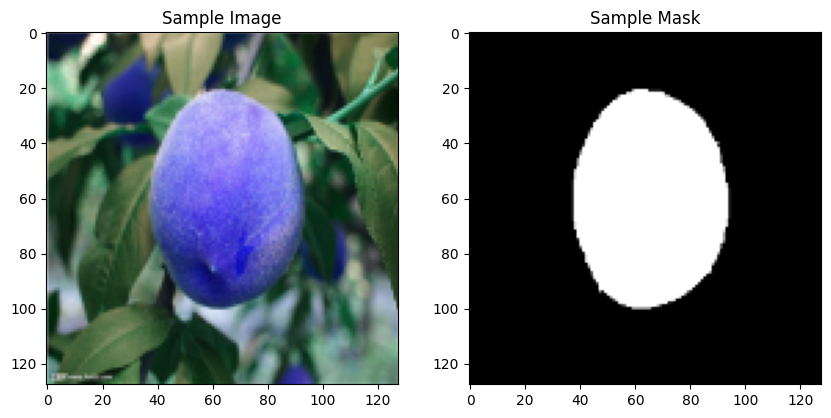

In [16]:
# CHECK A SAMPLE IMAGE AND ITS MASK

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

num_files = min(len(image_files), len(mask_files))

random_index = random.randint(0, num_files - 1)

sample_image_path = os.path.join(image_dir, image_files[random_index])
sample_mask_path = os.path.join(mask_dir, mask_files[random_index])

sample_image = np.load(sample_image_path)
sample_mask = np.load(sample_mask_path)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.title("Sample Image")
plt.imshow(sample_image)

plt.subplot(1, 2, 2)
plt.title("Sample Mask")
plt.imshow(sample_mask.squeeze(), cmap = 'gray') # .squeeze() REMOVES THE CHANNEL DIMENSION FOR MASKS
plt.show()

In [17]:
# CREATE AND SPLIT THE DATASET INTO A TRAINING (80%) AND A TESTING (20%) DATASETS

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = np.load(image_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)

        # CONVERT TO PyTorch TENSORS
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC -> CHW
        mask = torch.from_numpy(mask).permute(2, 0, 1)  # HWC -> CHW
        return image, mask

dataset = SegmentationDataset(image_dir, mask_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_dl = DataLoader(train_ds, batch_size = 16, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 8, shuffle = True)

print(f"Training dataset size: {len(train_ds)}")
print(f"Testing dataset size: {len(test_ds)}")

Training dataset size: 8000
Testing dataset size: 2000


---

**Train the model:**

In [18]:
# CREATE THE CLASS FOR DOUBLE CONVOLUTION

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# DEFINE THE UPSCALING FUNCTION

def Up(in_features, out_features):
    return nn.ConvTranspose2d(in_features, out_features, kernel_size=2, stride=2)

In [19]:
# CREATE THE CLASS WITH U-Net MODEL

class UNet(nn.Module):
    def __init__(self, features = 64):
        super().__init__()
        self.conv1 = Conv(3, features)
        self.conv2 = Conv(features, 2 * features)
        self.conv3 = Conv(2 * features, 4 * features)
        self.conv4 = Conv(4 * features, 8 * features)
        self.conv5 = Conv(8 * features, 16 * features)

        self.up1 = Up(16 * features, 8 * features)
        self.conv6 = Conv(16 * features, 8 * features)
        self.up2 = Up(8 * features, 4 * features)
        self.conv7 = Conv(8 * features, 4 * features)
        self.up3 = Up(4 * features, 2 * features)
        self.conv8 = Conv(4 * features, 2 * features)
        self.up4 = Up(2 * features, features)
        self.conv9 = Conv(2 * features, features)
        self.conv10 = nn.Conv2d(features, 1, 1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        l1 = self.conv1(x)                          # f x 448 x 256
        l2 = self.conv2(self.pool(l1))              # 2f x 224 x 128
        l3 = self.conv3(self.pool(l2))              # 4f x 112 x 64
        l4 = self.conv4(self.pool(l3))              # 8f x 56 x 32
        x = self.conv5(self.pool(l4))               # 16f x 28 x 16
        x = self.up1(x)                             # 8f x 56 x 32
        x = torch.cat([x, l4], dim = 1)             # 16f x 56 x 32
        x = self.conv6(x)                           # 8f x 56 x 32
        x = self.up2(x)                             # 4f x 112 x 64
        x = torch.cat([x, l3], dim = 1)             # 8f x 112 x 64
        x = self.conv7(x)                           # 4f x 112 x 64
        x = self.up3(x)                             # 2f x 224 x 128
        x = torch.cat([x, l2], dim = 1)             # 4f x 224 x 128
        x = self.conv8(x)                           # 2f x 224 x 128
        x = self.up4(x)                             # f x 448 x 256
        x = torch.cat([x, l1], dim = 1)             # 2f x 448 x 256
        x = self.conv9(x)                           # f x 448 x 256
        x = self.conv10(x)                          # 1 x 448 x 256
        return x

In [20]:
# DEFINE device, model, loss function, and optimalisation method

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(features = 16).to(device)

loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [21]:
# DEFINE THE FUNCTION FOR THE TRAINING LOOP

def train_loop():
    total_loss = 0

    for X,y in train_dl:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()

        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        loss.backward()
        opt.step()
        total_loss += loss.item()

    return total_loss

Epoch: 0 loss: 169.521188467741
Epoch: 1 loss: 117.86365206539631
Epoch: 2 loss: 106.7875343337655
Epoch: 3 loss: 99.15262362360954
Epoch: 4 loss: 93.40611901134253
Epoch: 5 loss: 88.37114481627941
Epoch: 6 loss: 84.04387993365526
Epoch: 7 loss: 80.95755583792925
Epoch: 8 loss: 77.27201705425978
Epoch: 9 loss: 71.67358299344778
Epoch: 10 loss: 67.32183051109314
Epoch: 11 loss: 62.646928042173386
Epoch: 12 loss: 58.63890688866377
Epoch: 13 loss: 54.316421024501324
Epoch: 14 loss: 49.58731469884515
Epoch: 15 loss: 47.9403037764132
Epoch: 16 loss: 43.779303565621376
Epoch: 17 loss: 41.23137925937772
Epoch: 18 loss: 38.74486108124256
Epoch: 19 loss: 36.63685808703303
Epoch: 20 loss: 34.30445055663586
Epoch: 21 loss: 33.820864506065845
Epoch: 22 loss: 31.40782456845045
Epoch: 23 loss: 31.06188664585352
Epoch: 24 loss: 30.046014431864023


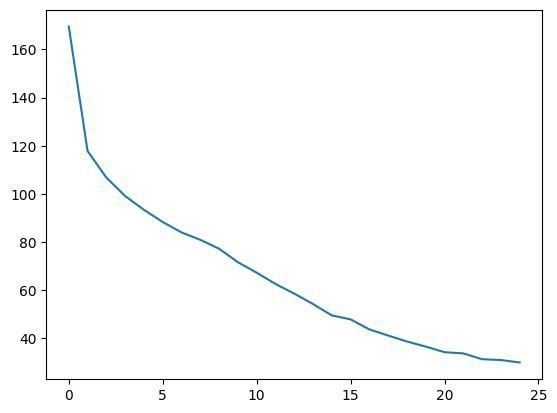

In [22]:
# EXECUTE TRAINING

loss_history = []

epochs = 25

model.train()

for epoch in range(epochs):
    loss = train_loop()
    loss_history.append(loss)
    print(f"Epoch: {epoch} loss: {loss}")

plt.plot(loss_history);

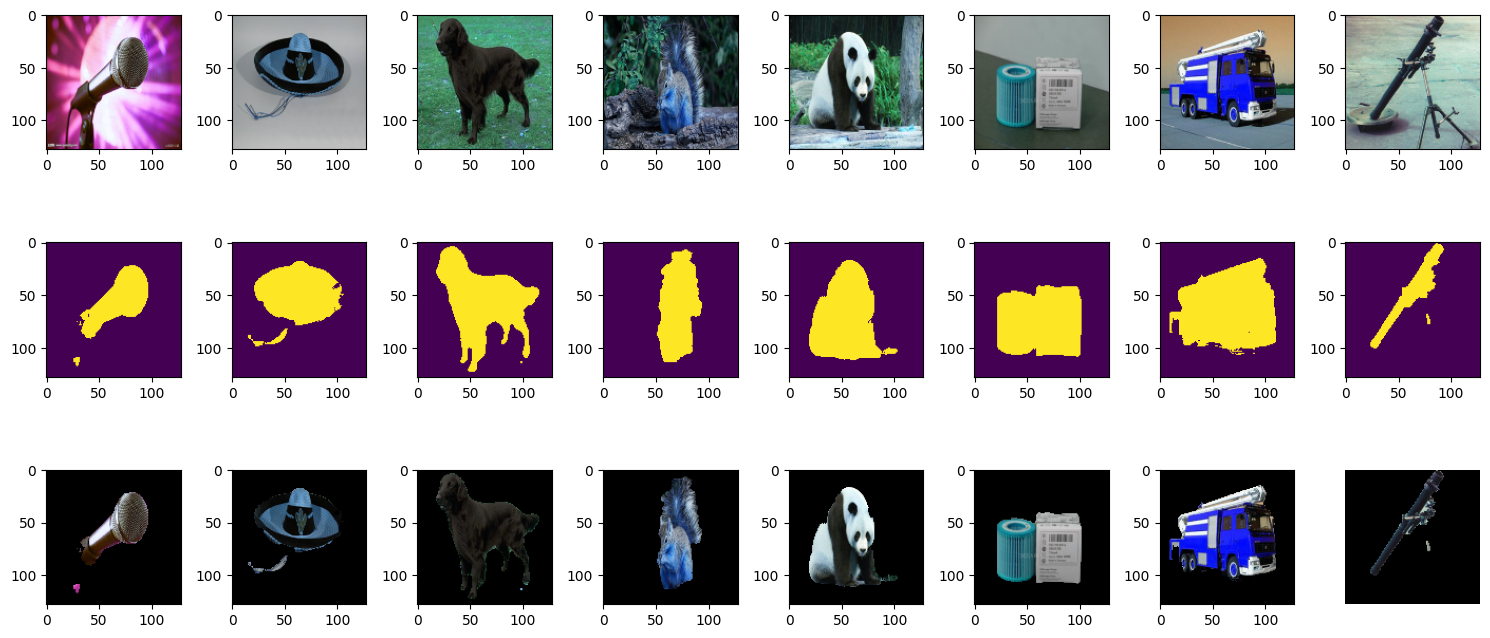

In [25]:
# MODEL EVALUATION

model.eval()

images, real_masks = next(iter(test_dl))

images = images.to(device)

preds = torch.sigmoid(model(images)) > 0.5

n = 8

fig, ax = plt.subplots(3, n, figsize = (15, 8), tight_layout = True)
plt.axis('off')

for i in range(n):
    ax.flat[i].imshow(images.cpu()[i].permute(1, 2, 0))
    ax.flat[n + i].imshow(preds[i][0].detach().cpu())
    ax.flat[2 * n + i].imshow((images.cpu()[i] * preds[i][0].detach().cpu()).permute(1, 2, 0))

---

***captum.ai:***

In [26]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:00


In [27]:
# IMPORTS

from captum.attr import IntegratedGradients, Saliency, visualization
from captum.attr import NoiseTunnel

# THE MODEL MUST BE IN THE EVALUATION MODE
model.eval()

UNet(
  (conv1): Conv(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): Conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv3): Conv(
    (conv): Sequential(
      (0): C

In [28]:
# INITIALISE Integrated Gradients METHOD (captum.ai)

ig = IntegratedGradients(model)

In [35]:
# DEFINE A FUNCTION TO VISUALISE LEARNING

def visualise(input_image, attributions):
    # CONVERT input_image TO NumPy FORMAT
    input_image = input_image.permute(1, 2, 0).cpu().numpy()  # HWC
    input_image = np.clip(input_image, 0, 1)  # NORMALISE IMAGE TO [0, 1]

    # AGGREGATE ATTRIBUTIONS (PIXELS) ACROSS CHANNELS
    attributions = attributions.mean(dim = 0).squeeze().cpu().detach().numpy()  # HW

    # NORMALISE ATTRIBUTIONS
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    # PLOT
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    ax[0].imshow(input_image)
    ax[0].axis('off')
    ax[0].set_title("Input Image")

    ax[1].imshow(attributions, cmap = "viridis")
    ax[1].axis('off')
    ax[1].set_title("Target Pixels")

    plt.tight_layout()
    plt.show()

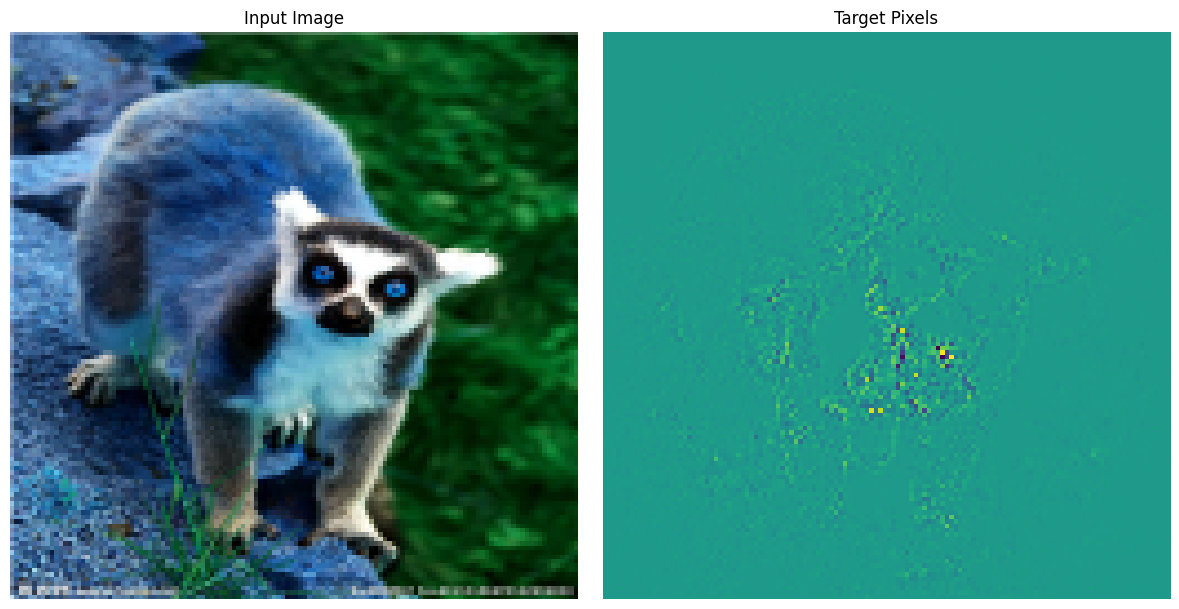

In [34]:
# COMPARE A SAMPLE IMAGE AND ITS TARGET PIXELS

# GET A BATCH FROM A TESTING DATASET
for X, y in test_dl:
    X, y = X.to(device), y.to(device)
    break

input_image = X[0].unsqueeze(0)  # ADD BATCH DIMENSION
ground_truth_mask = y[0].squeeze().cpu().numpy() # CONVERT A PyTorch TENSOR TO A NumPy ARRAY

# SELECT A PIXEL
target_pixel = (0, 64, 64)  # 0 -- BATCH INDEX, 64 -- ROW, 64 -- COLUMN (center pixel)

# COMPUTE ATTRIBUTIONS VIA Integrated Gradients
attributions = ig.attribute(input_image, target = target_pixel)

# VISUALISE
visualise(input_image[0], attributions[0])